100%|██████████| 113/113 [00:00<00:00, 154132.15it/s]


MolGridWidget(grid_id='filters')

interactive(children=(IntRangeSlider(value=(-3, 0), description='Score', max=0, min=-3), Output()), _dom_class…


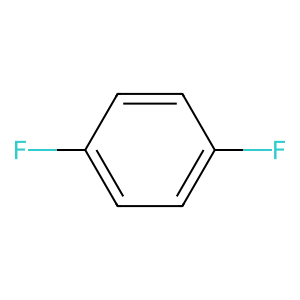
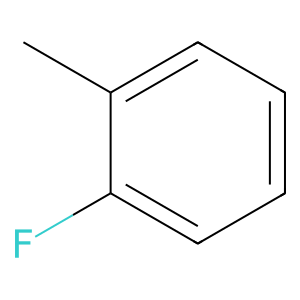
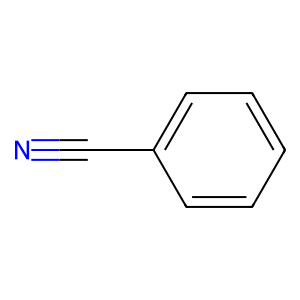
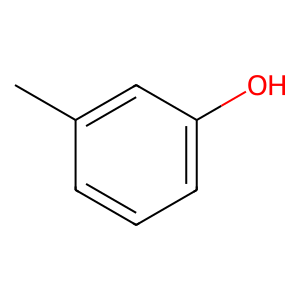
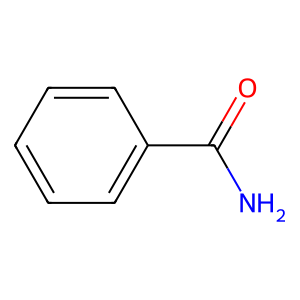
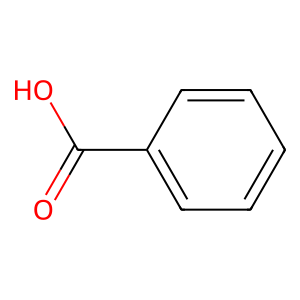
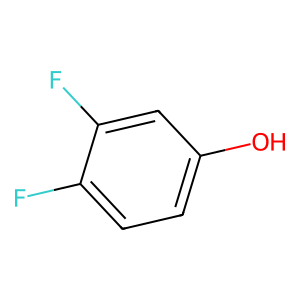
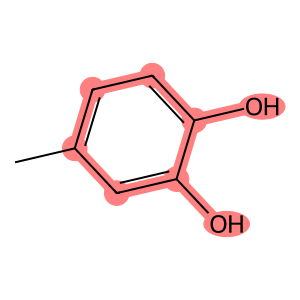
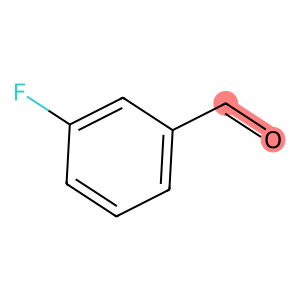
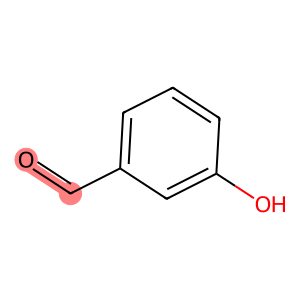
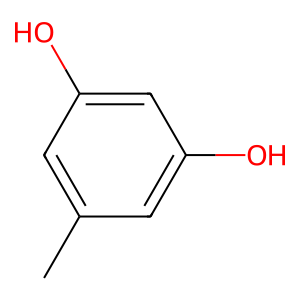
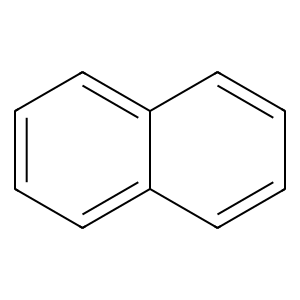
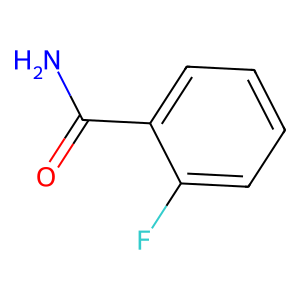
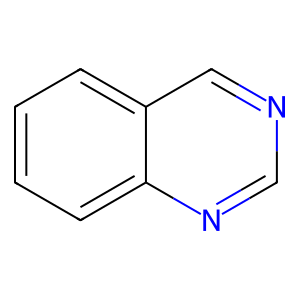
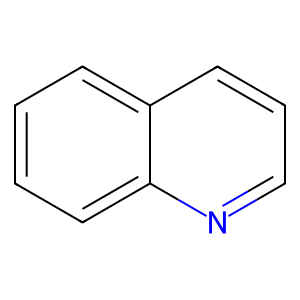
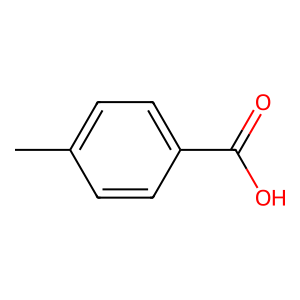
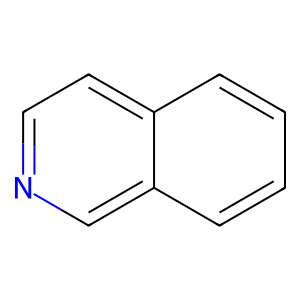
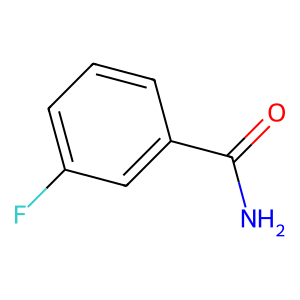
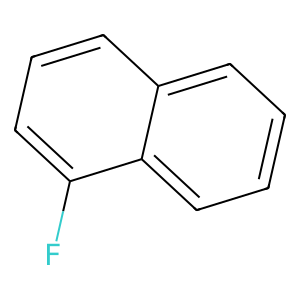
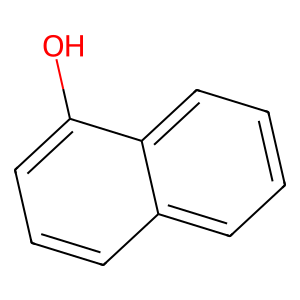
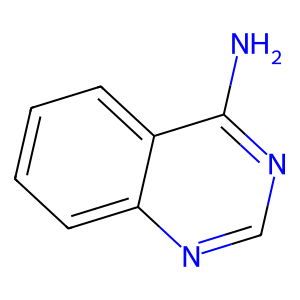
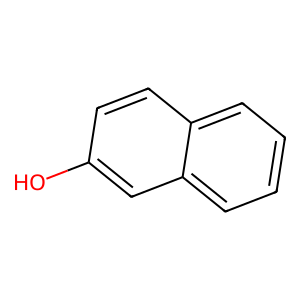
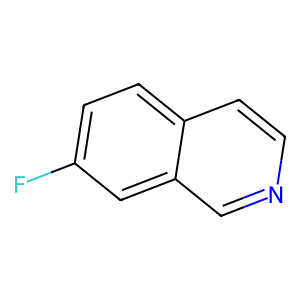
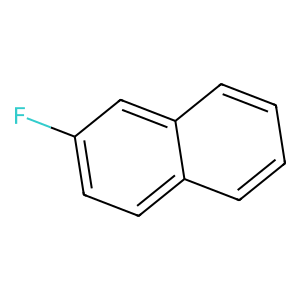
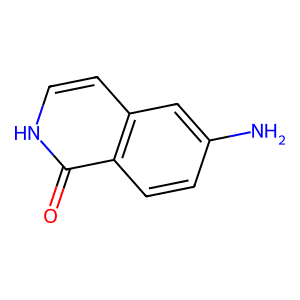
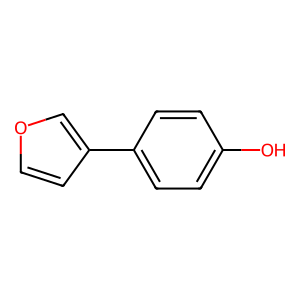
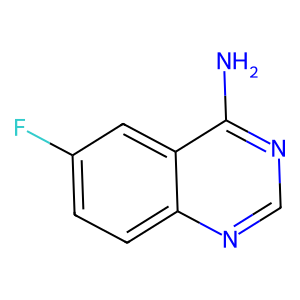
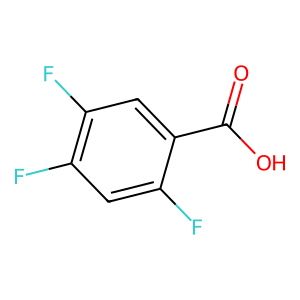
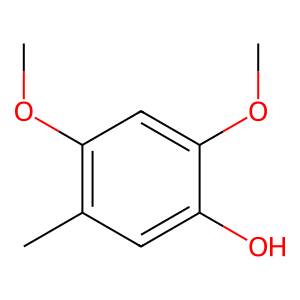
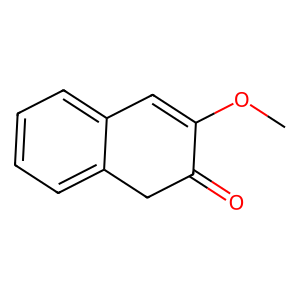
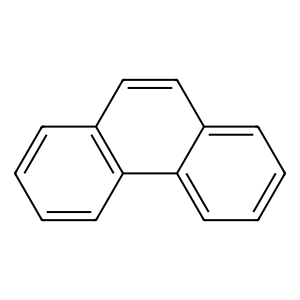
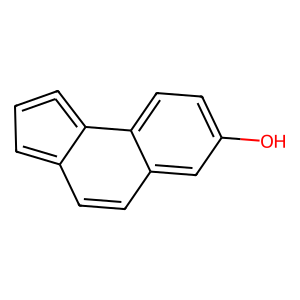
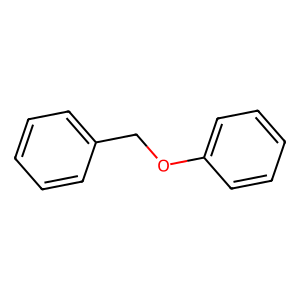
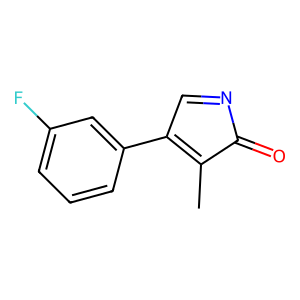
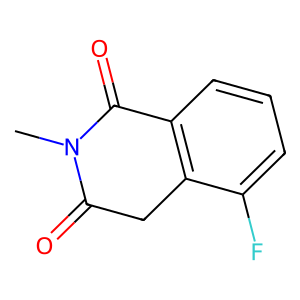
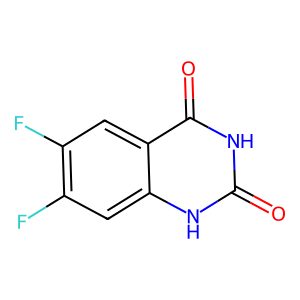
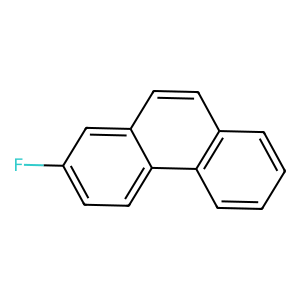
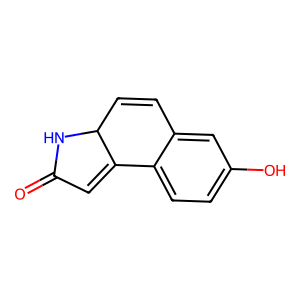
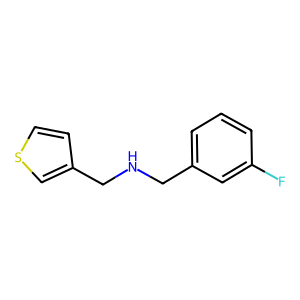
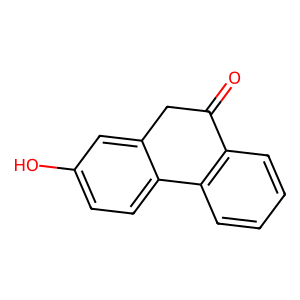
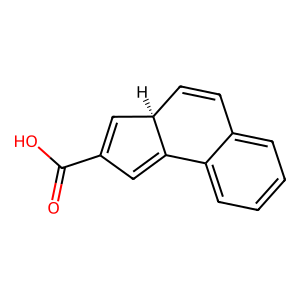
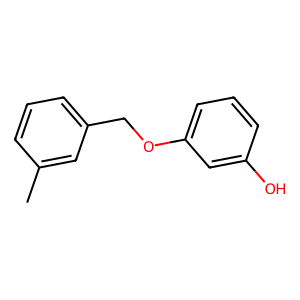
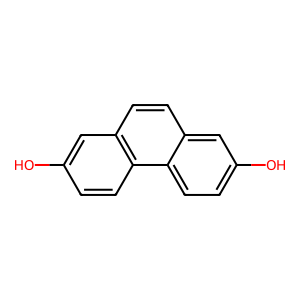
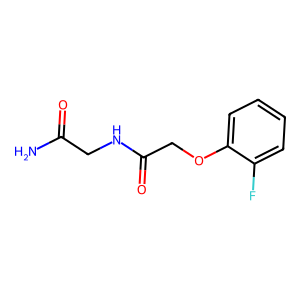
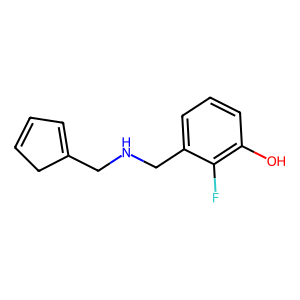
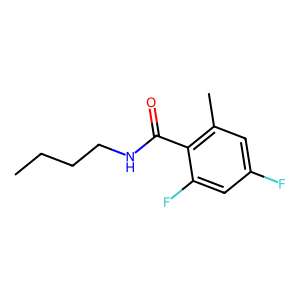
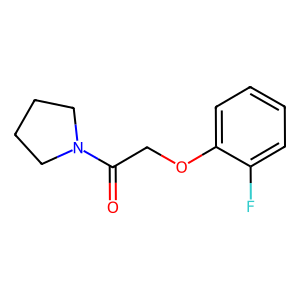
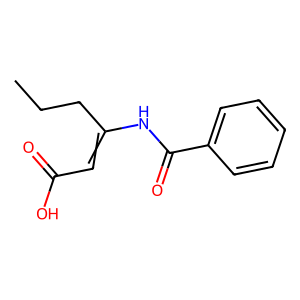
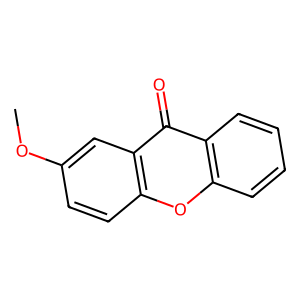
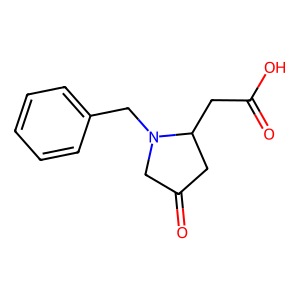
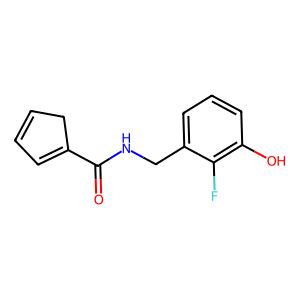
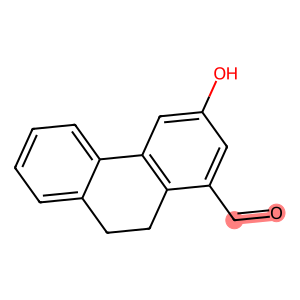
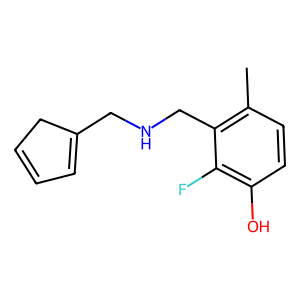
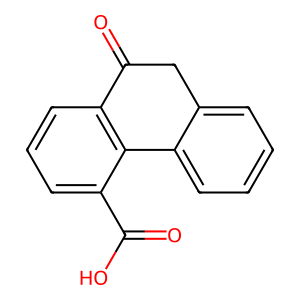
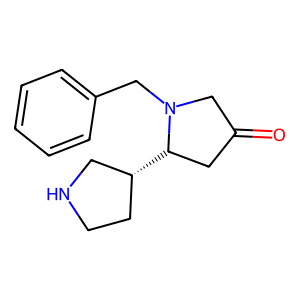
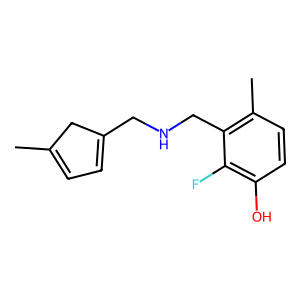
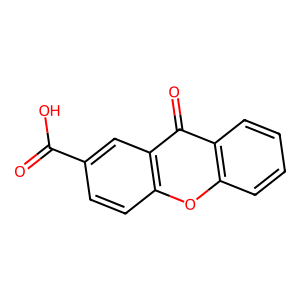
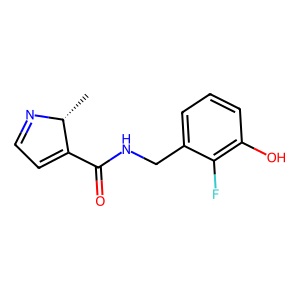
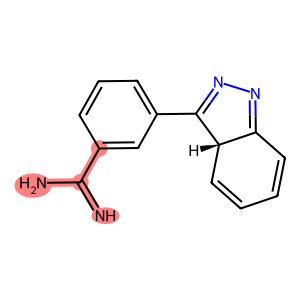
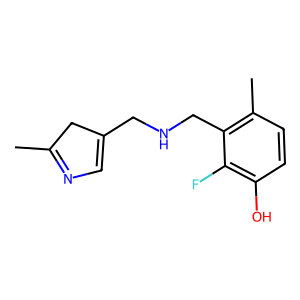
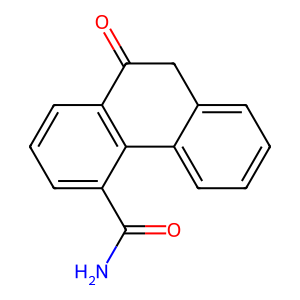
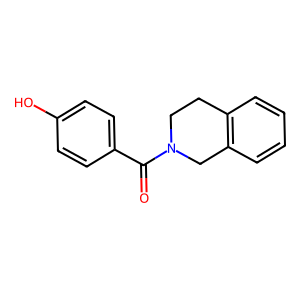
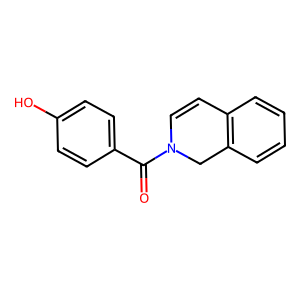
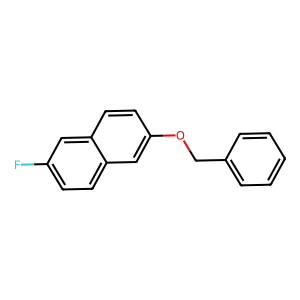
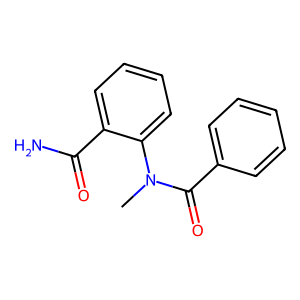
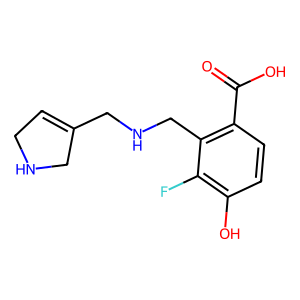
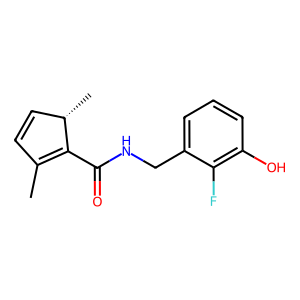
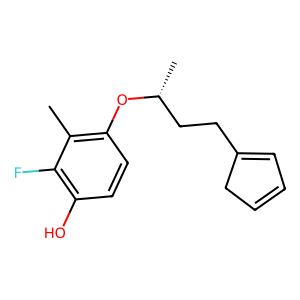
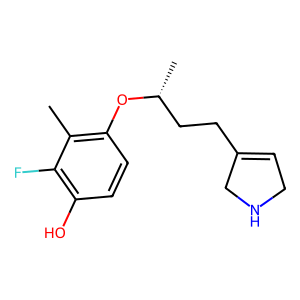
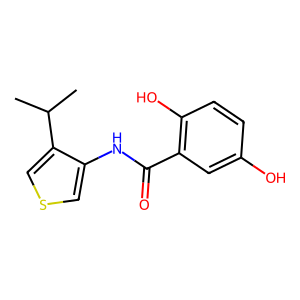
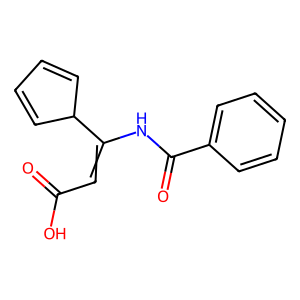
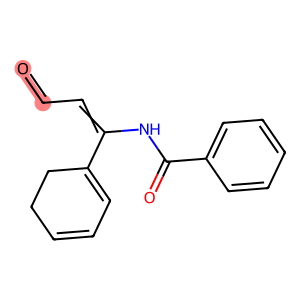
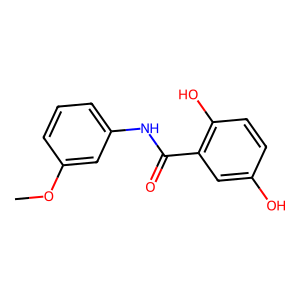
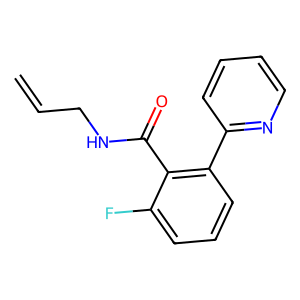
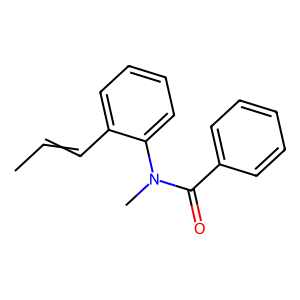
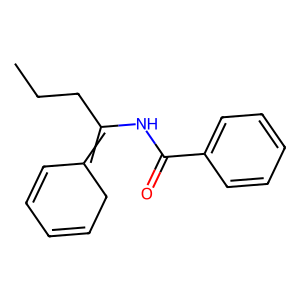
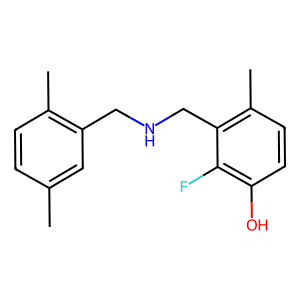
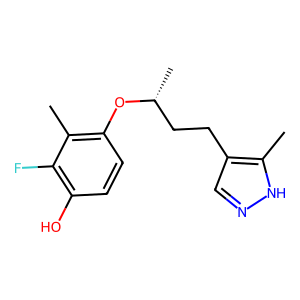
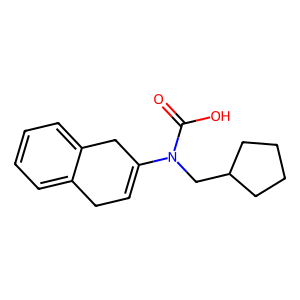
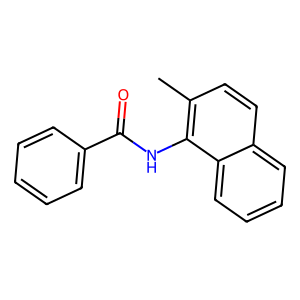
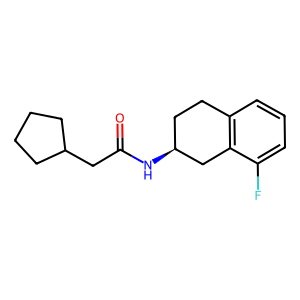
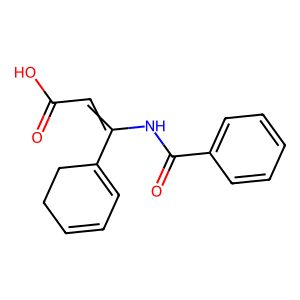
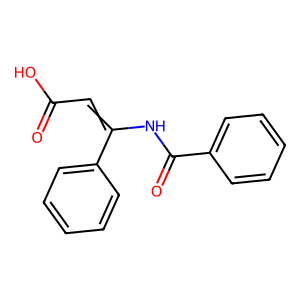
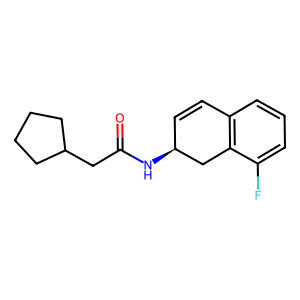
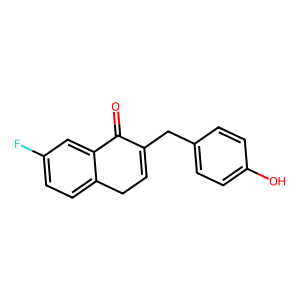
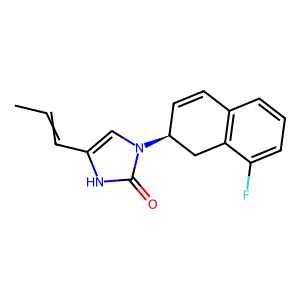
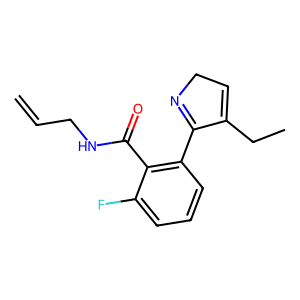
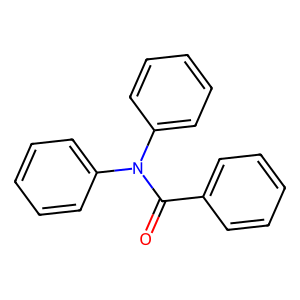
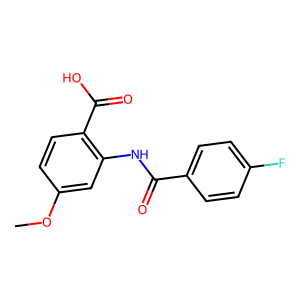
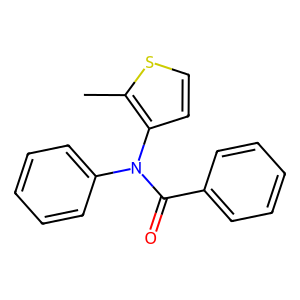
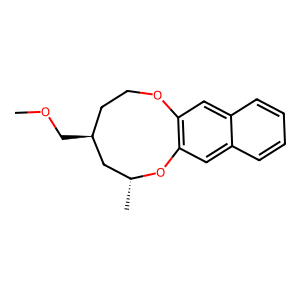
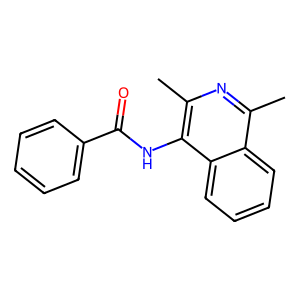
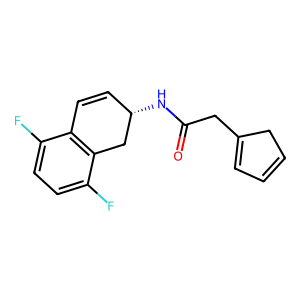
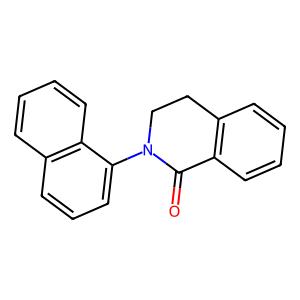
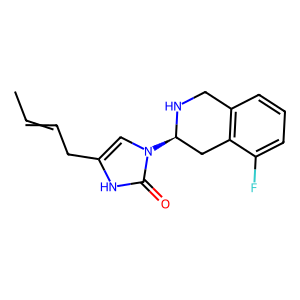
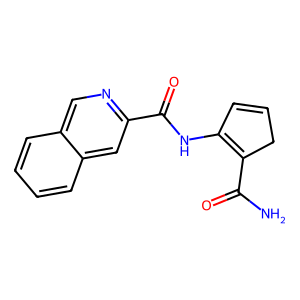
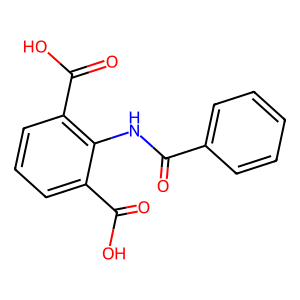
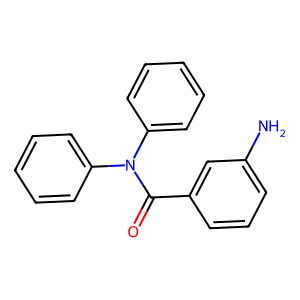
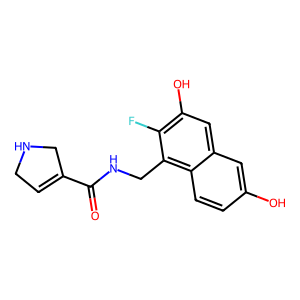
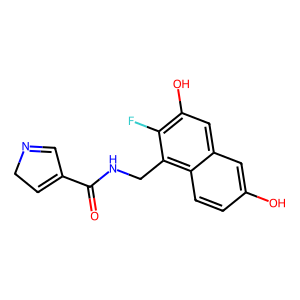
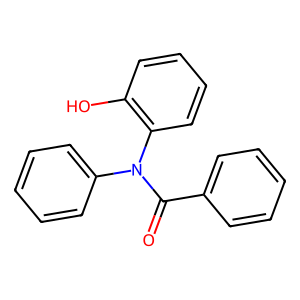
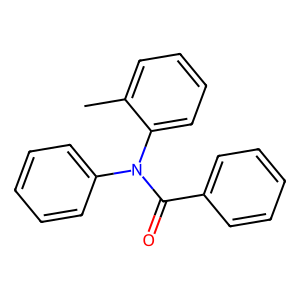
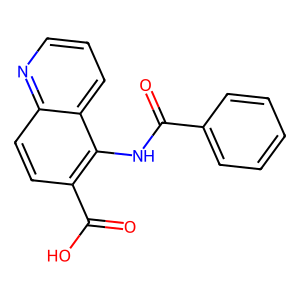
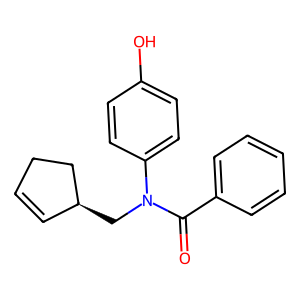
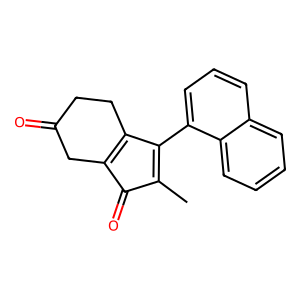
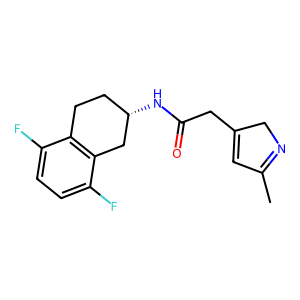
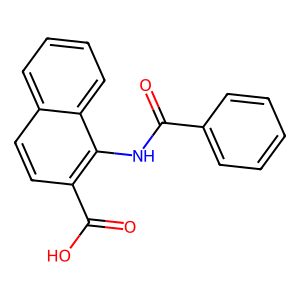
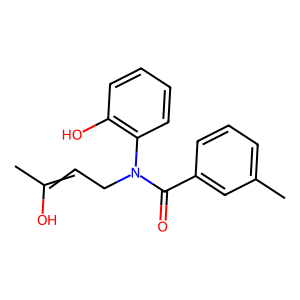
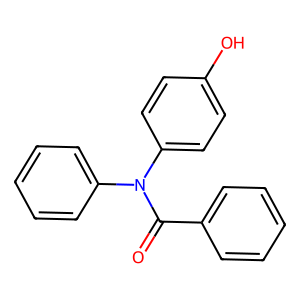
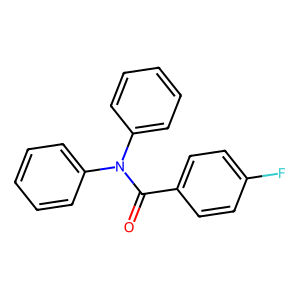
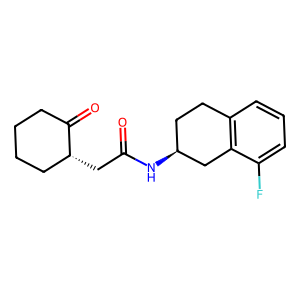
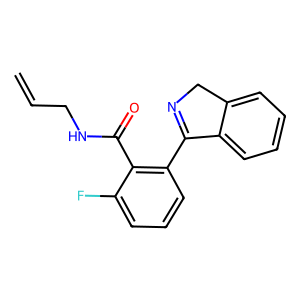
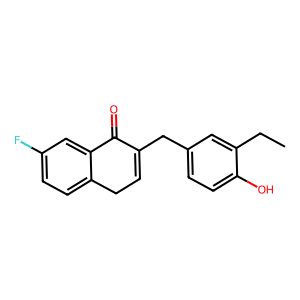

In [1]:
import base64
import io
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
import mols2grid
from IPython.display import display as ipy_display
import datamol as dm
import ipywidgets as widgets
from ipywidgets import interact
from joblib import Parallel, delayed
from tqdm import tqdm

class SDFMedChemGridViewer3Filters:
    def __init__(self, input_source, mcf_path, pains_path, wehi_pains_path, input_type="sdf", use_3d=False, image_size=(300, 300)):
        self.input_source = input_source
        self.input_type = input_type
        self.use_3d = use_3d
        self.image_size = image_size
        self.df = None
        self.mcf_filters = []
        self.pains_filters = []
        self.wehi_filters = []
        self.load_filters(mcf_path, pains_path, wehi_pains_path)
        
    def load_filters(self, mcf_path, pains_path, wehi_pains_path):
        mcf_df = pd.read_csv(mcf_path)
        for _, row in mcf_df.iterrows():
            filt = Chem.MolFromSmarts(row["smarts"])
            if filt:
                self.mcf_filters.append({"name": row["names"], "mol": filt})
        with open(pains_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) >= 2:
                    smarts = parts[0]
                    name = " ".join(parts[1:])
                    filt = Chem.MolFromSmarts(smarts)
                    if filt:
                        self.pains_filters.append({"name": name, "mol": filt})
        wehi_df = pd.read_csv(wehi_pains_path, header=None)
        wehi_df.columns = ["smarts", "name"]
        for _, row in wehi_df.iterrows():
            filt = Chem.MolFromSmarts(row["smarts"])
            if filt:
                self.wehi_filters.append({"name": row["name"], "mol": filt})
                
    def get_mols(self):
        if self.input_type == "sdf":
            supplier = Chem.SDMolSupplier(self.input_source)
            return [m for m in supplier if m is not None]
        elif self.input_type == "mols":
            return self.input_source
        elif self.input_type == "smiles":
            mols = []
            for smi in self.input_source:
                mol = Chem.MolFromSmiles(smi)
                if mol:
                    mols.append(mol)
            return mols
        return []
    
    def _process_single_mol(self, mol):
        if not self.use_3d:
            mol.RemoveAllConformers()
            rdDepictor.Compute2DCoords(mol)
        smiles = dm.to_smiles(mol)
        mcf_triggered, mcf_groups = self.check_filters(mol, self.mcf_filters)
        pains_triggered, pains_groups = self.check_filters(mol, self.pains_filters)
        wehi_triggered, wehi_groups = self.check_filters(mol, self.wehi_filters)
        score = (-1 if mcf_triggered else 0) + (-1 if pains_triggered else 0) + (-1 if wehi_triggered else 0)
        combined_groups = []
        if mcf_groups:
            combined_groups.extend(mcf_groups)
        if pains_groups:
            combined_groups.extend(pains_groups)
        if wehi_groups:
            combined_groups.extend(wehi_groups)
        img = self.mol_to_base64_img(mol, combined_groups)
        return {
            "SMILES": smiles,
            "MCF_Filters": ", ".join(mcf_triggered) if mcf_triggered else "Passed",
            "PAINS_Filters": ", ".join(pains_triggered) if pains_triggered else "Passed",
            "WEHI_Filters": ", ".join(wehi_triggered) if wehi_triggered else "Passed",
            "Total_Score": score,
            "img": img,
            "mol": mol
        }
    
    def process_input(self):
        mols = self.get_mols()
        records = Parallel(n_jobs=-1, backend="threading")(
            delayed(self._process_single_mol)(mol) for mol in tqdm(mols)
        )
        self.df = pd.DataFrame(records)
        return self.df
    
    def check_filters(self, mol, filter_list):
        triggered = []
        groups = []
        for filt in filter_list:
            matches = mol.GetSubstructMatches(filt["mol"])
            if matches:
                triggered.append(filt["name"])
                groups.extend(matches)
        return triggered, groups if groups else None
    
    def get_highlight_bonds(self, mol, groups):
        bonds = set()
        for group in groups:
            for bond in mol.GetBonds():
                a1 = bond.GetBeginAtomIdx()
                a2 = bond.GetEndAtomIdx()
                if a1 in group and a2 in group:
                    bonds.add(bond.GetIdx())
        return list(bonds)
    
    def mol_to_base64_img(self, mol, groups):
        if groups:
            highlight_atoms = set()
            for group in groups:
                highlight_atoms.update(group)
            highlight_atoms = list(highlight_atoms)
            highlight_bonds = self.get_highlight_bonds(mol, groups)
        else:
            highlight_atoms = None
            highlight_bonds = None
        img = Draw.MolToImage(mol, size=self.image_size, highlightAtoms=highlight_atoms, highlightBonds=highlight_bonds)
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        b64_img = base64.b64encode(buf.getvalue()).decode("utf-8")
        return f"<img src='data:image/png;base64,{b64_img}'/>"
    
    def display_grid(self):
        if self.df is None:
            print("DataFrame is empty, run process_input() first.")
            return
        grid = mols2grid.MolGrid(
            self.df,
            smiles_col="SMILES",
            mol_col="mol",
            subset=["MCF_Filters", "PAINS_Filters", "WEHI_Filters", "Total_Score"],
            tooltip=["SMILES", "MCF_Filters", "PAINS_Filters", "WEHI_Filters", "Total_Score"],
            size=(100, 80),
            name="filters",
            prerender=True
        )
        grid.mol_to_img = lambda m: self.df.loc[self.df["SMILES"] == dm.to_smiles(m), "img"].iloc[0]
        grid._prepare_dataframe(grid.dataframe)
        def filter_grid(Score):
            results = grid.dataframe.query("(@Score[0] <= Total_Score <= @Score[1])")
            return grid.filter_by_index(results.index)
        interact_widget = interact(filter_grid, Score=widgets.IntRangeSlider(value=[-3, 0], min=-3, max=0, step=1))
        grid_view = grid.display(
                                 style={
                                     "MCF_Filters": lambda x: "color: red; font-weight: bold;" if x != "Passed" else "",
                                     "PAINS_Filters": lambda x: "color: red; font-weight: bold;" if x != "Passed" else "",
                                     "WEHI_Filters": lambda x: "color: red; font-weight: bold;" if x != "Passed" else ""
                                 })
        ipy_display(grid_view)
    
    def show(self):
        self.process_input()
        self.display_grid()

viewer = SDFMedChemGridViewer3Filters("6gj7_F0B_ligand_gen.sdf", "data/mcf.csv", "data/pains.txt", "data/wehi_pains.csv", input_type="sdf", use_3d=False)
viewer.show()